# Web Mining and Applied NLP (44-620)

## Final Project: Article Summarizer

### Student Name: Brett Neely

Perform the tasks described in the Markdown cells below.  When you have completed the assignment make sure your code cells have all been run (and have output beneath them) and ensure you have committed and pushed ALL of your changes to your assignment repository.

You should bring in code from previous assignments to help you answer the questions below.

Every question that requires you to write code will have a code cell underneath it; you may either write your entire solution in that cell or write it in a python file (`.py`), then import and run the appropriate code to answer the question.

In [1]:
from bs4 import BeautifulSoup
import requests
import html5lib
import pickle
import matplotlib.pyplot as plt
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from collections import Counter

1. Find on the internet an article or blog post about a topic that interests you and you are able to get the text for using the technologies we have applied in the course.  Get the html for the article and store it in a file (which you must submit with your project)

In [2]:
URL = 'https://en.wikipedia.org/wiki/Database'
response = requests.get(URL)
article = response.text

In [3]:
# Wrtie to a pickle file
with open('article.pkl', 'wb') as file:
    pickle.dump(article, file)

2. Read in your article's html source from the file you created in question 1 and do sentiment analysis on the article/post's text (use `.get_text()`).  Print the polarity score with an appropriate label.  Additionally print the number of sentences in the original article (with an appropriate label)

In [4]:
# Print the article text with Beautiful Soup
soup = BeautifulSoup(article, 'html.parser')
content_div = soup.find('div', {'class': 'mw-parser-output'})
paragraphs = content_div.find_all('p')
article_text = '\n'.join([para.get_text(separator=' ',strip=True) for para in paragraphs if para.get_text(strip=True)])

print(article_text)

In computing , a database is an organized collection of data or a type of data store based on the use of a database management system ( DBMS ), the software that interacts with end users , applications , and the database itself to capture and analyze the data. The DBMS additionally encompasses the core facilities provided to administer the database. The sum total of the database, the DBMS and the associated applications can be referred to as a database system . Often the term "database" is also used loosely to refer to any of the DBMS, the database system or an application associated with the database.
Small databases can be stored on a file system , while large databases are hosted on computer clusters or cloud storage . The design of databases spans formal techniques and practical considerations, including data modeling , efficient data representation and storage, query languages , security and privacy of sensitive data, and distributed computing issues, including supporting concurre

In [14]:
# Number of sentences
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")
doc = nlp(article_text)

number_of_sentences = len(list(doc.sents))
print(f"The article contains {number_of_sentences} number of sentences.")

The article contains 286 number of sentences.


In [17]:
# Polarity Score
polarity_score = round(doc._.blob.polarity, 2)
print(f"The polarity score of this article is {polarity_score}.")

The polarity score of this article is 0.09.


3. Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent tokens (converted to lower case).  Print the common tokens with an appropriate label.  Additionally, print the tokens their frequencies (with appropriate labels)

In [18]:
tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct]
token_counts = Counter(tokens)
most_common_tokens = token_counts.most_common(5)

print(f"The five most common tokens are {most_common_tokens}.")

The five most common tokens are [('database', 178), ('data', 132), ('\n', 98), ('model', 57), ('dbms', 48)].


4. Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent lemmas (converted to lower case).  Print the common lemmas with an appropriate label.  Additionally, print the lemmas with their frequencies (with appropriate labels).

In [19]:
lemmas = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
lemma_counts = Counter(lemmas)
most_common_lemmas = lemma_counts.most_common(5)

print(f"The five most common lemmas are {most_common_lemmas}.")

The five most common lemmas are [('database', 221), ('\n', 98), ('datum', 97), ('model', 70), ('dbms', 65)].


5. Make a list containing the scores (using tokens) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores. From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

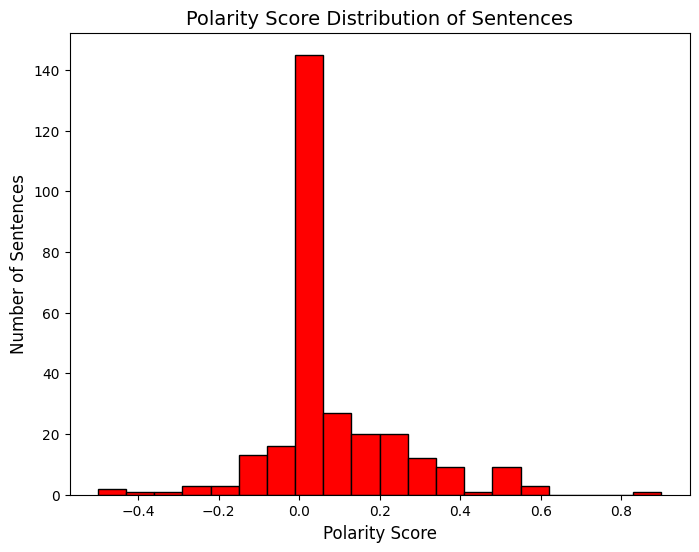

In [ ]:
sentence_polarities = [sent._.blob.polarity for sent in doc.sents]
plt.figure(figsize=(8, 6))
plt.hist(sentence_polarities, bins=20, edgecolor='black', color='red')

plt.title("Polarity Score Distribution of Sentences", fontsize=14)
plt.xlabel("Polarity Score", fontsize=12)
plt.ylabel("Number of Sentences", fontsize=12)

plt.show()

# The most common range of scores is 0.0 to 0.1.

6. Make a list containing the scores (using lemmas) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores.  From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

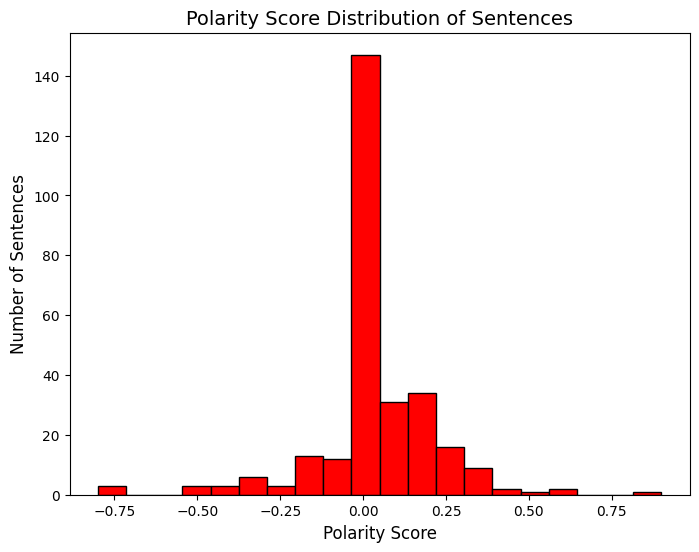

In [ ]:
lemma_polarities = []

for sent in doc.sents:
    lemmas = [token.lemma_.lower() for token in sent if not token.is_stop and not token.is_punct]
    lemmas_text = " ".join(lemmas)
    lemmas_doc = nlp(lemmas_text)
    sentence_lemma_polarity = lemmas_doc._.blob.polarity
    lemma_polarities.append(sentence_lemma_polarity)

plt.figure(figsize=(8, 6))
plt.hist(lemma_polarities, bins=20, edgecolor='black', color='red')

plt.title("Polarity Score Distribution of Sentences", fontsize=14)
plt.xlabel("Polarity Score", fontsize=12)
plt.ylabel("Number of Sentences", fontsize=12)

plt.show()

# The most common range of scores is around 0.0.

7. Using the histograms from questions 5 and 6, decide a "cutoff" score for tokens and lemmas such that fewer than half the sentences would have a score greater than the cutoff score.  Record the scores in this Markdown cell

* Cutoff Score (tokens): 0.3
* Cutoff Score (lemmas): 0.01

Feel free to change these scores as you generate your summaries.  Ideally, we're shooting for at least 6 sentences for our summary, but don't want more than 10 (these numbers are rough estimates; they depend on the length of your article).

8. Create a summary of the article by going through every sentence in the article and adding it to an (initially) empty list if its score (based on tokens) is greater than the cutoff score you identified in question 8.  If your loop variable is named `sent`, you may find it easier to add `sent.text.strip()` to your list of sentences.  Print the summary (I would cleanly generate the summary text by `join`ing the strings in your list together with a space (`' '.join(sentence_list)`).

In [29]:
summary_sentences = []
# Choosing 0.3 to show a the article cut down significantly
cutoff_score = 0.3

for sent in doc.sents:
    sentence_polarity = sent._.blob.polarity
    if sentence_polarity > cutoff_score:
        summary_sentences.append(sent.text)

summary = " ".join(summary_sentences)

print(summary)

Hardware database accelerators, connected to one or more servers via a high-speed channel, are also used in large-volume transaction processing environments . DBMSs are found at the heart of most database applications . [ citation needed ]
Since DBMSs comprise a significant market , computer and storage vendors often take into account DBMS requirements in their own development plans. Many CODASYL databases also added a declarative query language for end users (as distinct from the navigational API ). IBM also had its own DBMS in 1966, known as Information Management System (IMS). The use of primary keys (user-oriented identifiers) to represent cross-table relationships, rather than disk addresses, had two primary motivations. Thus most database systems nowadays are software systems running on general-purpose hardware, using general-purpose computer data storage. Codd's ideas were establishing themselves as both workable and superior to CODASYL, pushing IBM to develop a true production 

9. Print the polarity score of your summary you generated with the token scores (with an appropriate label). Additionally, print the number of sentences in the summarized article.

In [32]:
summary_doc = nlp(summary)
summary_polarity = summary_doc._.blob.polarity

print(f"The polarity score for the summary is {summary_polarity} and the number of sentences in the summary is {len(list(summary_doc.sents))}.")

The polarity score for the summary is 0.42335359675785217 and the number of sentences in the summary is 26.


10. Create a summary of the article by going through every sentence in the article and adding it to an (initially) empty list if its score (based on lemmas) is greater than the cutoff score you identified in question 8.  If your loop variable is named `sent`, you may find it easier to add `sent.text.strip()` to your list of sentences.  Print the summary (I would cleanly generate the summary text by `join`ing the strings in your list together with a space (`' '.join(sentence_list)`).

In [46]:
summary_sentences = []
# Choosing 0.01 to show a the article cut down significantly
cutoff_lemmas = 0.1

for sent in doc.sents:
    lemmas = [token.lemma_ for token in sent if not token.is_stop and not token.is_punct]
    lemmas_text = " ".join(lemmas)
    lemmas_doc = nlp(lemmas_text)
    sentence_polarity = lemmas_doc._.blob.polarity
    if sentence_polarity > cutoff_score:
        summary_sentences.append(sent.text)

# Combine selected sentences to form the summary
summary = " ".join(summary_sentences)
print(summary)

[ citation needed ]
Since DBMSs comprise a significant market , computer and storage vendors often take into account DBMS requirements in their own development plans. Codd's ideas were establishing themselves as both workable and superior to CODASYL, pushing IBM to develop a true production version of System R, known as SQL/DS , and, later, Database 2 ( IBM Db2 ).
 The dBASE product was lightweight and easy for any computer user to understand out of the box. Database languages are special-purpose languages, which allow one or more of the following tasks, sometimes distinguished as sublanguages :
 The downsides of materialized views are the overhead incurred when updating them to keep them synchronized with their original updated database data, and the cost of storage redundancy.
 Database access controls are set by special authorized (by the database owner) personnel that uses dedicated protected security DBMS interfaces.
 Each transaction has well defined boundaries in terms of which 

11. Print the polarity score of your summary you generated with the lemma scores (with an appropriate label). Additionally, print the number of sentences in the summarized article.

In [48]:
summary_doc = nlp(summary)
summary_polarity = summary_doc._.blob.polarity

print(f"The polarity score for the summary is {summary_polarity} and the number of sentences in the summary is {len(list(summary_doc.sents))}.")

The polarity score for the summary is 0.40180890538033404 and the number of sentences in the summary is 14.


12.  Compare your polarity scores of your summaries to the polarity scores of the initial article.  Is there a difference?  Why do you think that may or may not be?.  Answer in this Markdown cell.  

The initial polarity score was 0.09 of the article, the tokens cutoff score was 0.4 and the lemmas cutoff score was also 0.4 so they are significantly higher than the whole article. This may be because I wasn't selecting the "exact" cutoff point.

13. Based on your reading of the original article, which summary do you think is better (if there's a difference).  Why do you think this might be?

Since this is a technical article, I think the lemmas summary is more accurate.